In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


In [ ]:
image_size = (32, 32)


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# ----------- Class Conditional UNet (Minimal) -----------
class ClassConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, num_classes=28, base_channels=64):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, base_channels)
        self.in_channels = in_channels
        self.base_channels = base_channels

        self.conv1 = nn.Conv2d(in_channels + base_channels, base_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(base_channels, in_channels, 3, padding=1)

    def forward(self, x, t, class_labels):
        B, C, H, W = x.shape
        c_emb = self.class_emb(class_labels).view(B, self.base_channels, 1, 1).expand(B, self.base_channels, H, W)
        x = torch.cat([x, c_emb], dim=1)  # shape: [B, C + base_channels, H, W]
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        out = self.conv3(h)
        return out


# ----------- Scheduler (DDPM) -----------
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------- Training Config -----------
checkpoint = torch.load("/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/model/diffusion/class_cond_unet_checkpoint30.pth", map_location=device)

model = ClassConditionalUNet(in_channels=4).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ClassConditionalUNet(
  (class_emb): Embedding(28, 64)
  (conv1): Conv2d(68, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
@torch.no_grad()
def sample_same_noise_diff_classes(model, noise_scheduler, class_labels, num_steps=1000, image_size=32):
    model.eval()
    batch_size = len(class_labels)
    x = torch.randn(batch_size, 4, image_size, image_size).to(device)  # same noise base
    labels = torch.tensor(class_labels, device=device, dtype=torch.long)

    for t in reversed(range(num_steps)):
        t_tensor = torch.full((batch_size,), t, device=device)
        noise_pred = model(x, t_tensor, labels)
        x = noise_scheduler.step(noise_pred, t_tensor.cpu()[0], x).prev_sample

    return x.clamp(0, 1)


In [ ]:
samples = sample_same_noise_diff_classes(model, noise_scheduler, class_labels=[0, 1, 2, 3])


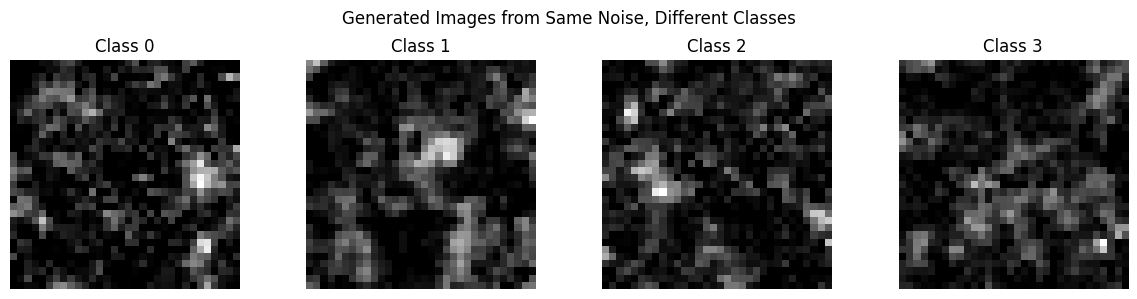

In [ ]:
import matplotlib.pyplot as plt

samples = samples.cpu()

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img = samples[i, 0]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Class {i}")
    axs[i].axis('off')

plt.suptitle("Generated Images from Same Noise, Different Classes")
plt.tight_layout()
plt.show()


In [ ]:
@torch.no_grad()
def sample_batch(model, noise_scheduler, class_label, batch_size=64, num_steps=1000, image_size=32):
    model.eval()
    x = torch.randn(batch_size, 4, image_size, image_size).to(device)
    labels = torch.full((batch_size,), class_label, device=device, dtype=torch.long)

    for t in reversed(range(num_steps)):
        t_tensor = torch.full((batch_size,), t, device=device)
        noise_pred = model(x, t_tensor, labels)
        x = noise_scheduler.step(noise_pred, t_tensor.cpu()[0], x).prev_sample



    return x.clamp(0, 1)  # shape: [B, 4, H, W]


In [ ]:
import os
import torchvision.utils as vutils

output_dir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/diffusion model mix/generated_images/"
os.makedirs(output_dir, exist_ok=True)

for cls in range(28):
    class_dir = os.path.join(output_dir, f"class_{cls}")
    os.makedirs(class_dir, exist_ok=True)

    images = []
    for i in range(400 // 64):
        batch_imgs = sample_batch(model, noise_scheduler, class_label=cls, batch_size=64)
        batch_imgs = batch_imgs.cpu()

        for j in range(batch_imgs.size(0)):
            img = batch_imgs[j]
            filename = os.path.join(class_dir, f"class_{cls}_{i * 64 + j:03d}.png")
            vutils.save_image(img, filename, normalize=True, value_range=(0, 1))
